# Chapter 3 - Classification

Inspired by: https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

## Load the data

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.dtype

dtype('float64')

In [6]:
y.dtype

dtype('O')

In [7]:
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train and evaluate a Binary Classifier

To use the MNIST dataset for binary classification we can frame it as a problem where we need to distinguish between 5's and non-5's.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
sgd_cv_scores = cross_val_score(sgd_clf,
                                X_train, y_train_5,
                                cv=skfolds, scoring="accuracy")

In [12]:
sgd_cv_scores

array([0.9669 , 0.91625, 0.96785])

Let's compare it with a classifier that never predicts 5's (returns False's only).

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
n5c_clf = Never5Classifier()
n5c_cv_scores = cross_val_score(n5c_clf,
                                X_train, y_train_5,
                                cv=skfolds, scoring="accuracy")

In [15]:
n5c_cv_scores

array([0.90965, 0.90965, 0.90965])

In [16]:
prop5 = y_train_5.sum()/len(y_train_5)
print(f"{prop5:.1%}")

9.0%


Since only 9% of the data are 5's, it's fairly easy to get high accuracy. But what about precision and recall?

In [17]:
def print_scores(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.1%}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.1%}")
    print(f"Recall: {recall_score(y_true, y_pred):.1%}")
    print(f"F1-score: {f1_score(y_true, y_pred):.1%}")

In [18]:
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=skfolds)
print_scores(y_train_5, sgd_pred)

Accuracy: 95.0%
Precision: 69.8%
Recall: 79.5%
F1-score: 74.3%


In [19]:
n5c_pred = cross_val_predict(n5c_clf, X_train, y_train_5, cv=skfolds)
print_scores(y_train_5, n5c_pred)

Accuracy: 91.0%
Precision: 0.0%
Recall: 0.0%
F1-score: 0.0%


In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=None):
    """
    Plot the precisions and recalls functions for different thresholds over the x-axis
    as well as the point-estimate precision and recall corresponding to a condition
    """
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-thresholds.max(), thresholds.max(), 0, 1])
    
    if cond is None:
        cond = np.argmax(thresholds >= .0)
        
    thr = thresholds[cond]
    rec = recalls[cond]
    pre = precisions[cond]
    
    plt.plot([thr, thr], [0, pre], "r:")
    plt.plot([-thresholds.max(), thr], [pre, pre], "r:")
    plt.plot([thr], [pre], "ro")

    plt.plot([thr, thr], [0, rec], "r:")
    plt.plot([-thresholds.max(), thr], [rec, rec], "r:")
    plt.plot([thr], [rec], "ro")

    plt.title(f"At a threshold of {thr:.0f}, precision is {pre:.1%} and recall is {rec:.1%}")
    plt.show()

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=skfolds,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

The default threshold is 0

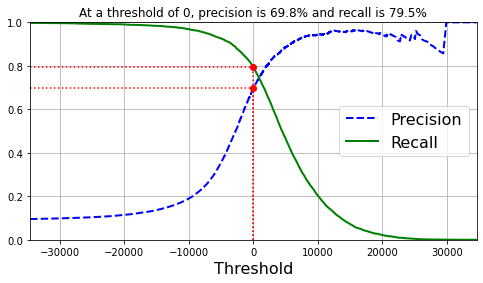

In [22]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

## Customize classifier to precision/recall requirements

Sometimes we might want to optimize the precision-recall tradeoff depending on our problem.

For example, if we're working on a spam filter we want to maximize precision (minimize false positives ie genuine emails sent to spam folder) and don't care too much about recall (it's fine if we get to see some spam). But at the same time, we might not want the recall to be so low, to make a spam filter pointless.

On the other hand, if we're working on a faulty detector we want to maximize recall (don't want to send faulty products to our customers) and don't care too much about precision (we assume that a genuine product detected as faulty will be sent off for manual inspection and the mistake rectified and we also assume that the cost of reclaiming/brand damage are a lot higher than the ones related to manually inspect false positives.



Let's say we want **90+% precision** from our 5's vs non-5's classifier

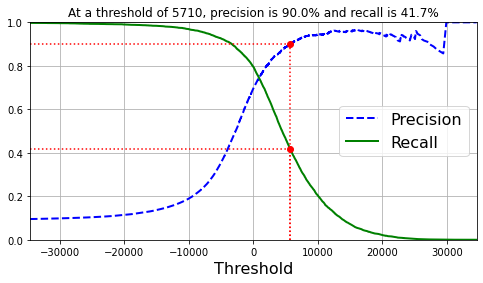

In [23]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmax(precisions >= .90))

Let's say we want **99+% precision**

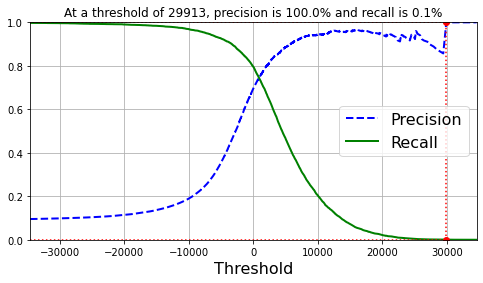

In [24]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmax(precisions >= .99))

Let's say we want **90+% recall**

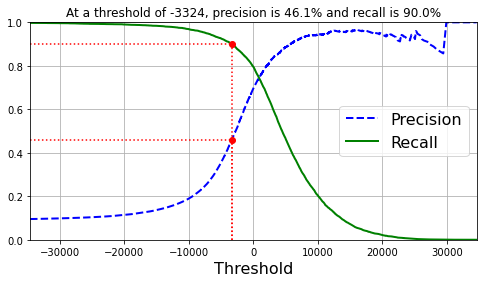

In [25]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmin(recalls >= .9) - 1)

Let's say we want the same level of precision and recall

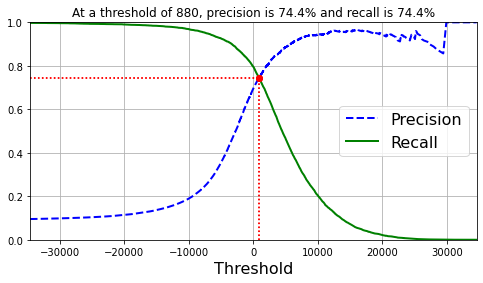

In [26]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmax(np.isclose(precisions, recalls)))

Let's say we want to **maximize precision** but **no less than 5% recall**.

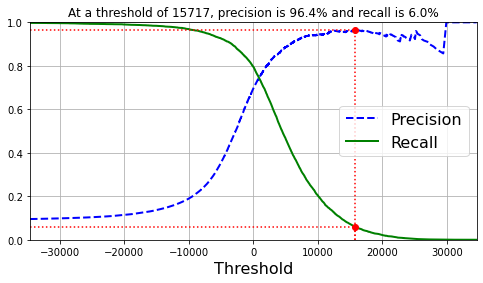

In [27]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=precisions[recalls >= 0.05].argmax())

Without this chart, one would probably expect that further decreasing recall (from 6% to 5%) would give an even higher precision, but we can see how it's not the case (it drops by 0.3 percentage points). One would have to go to near-zero recalls to get a precision higher than 96.4%.

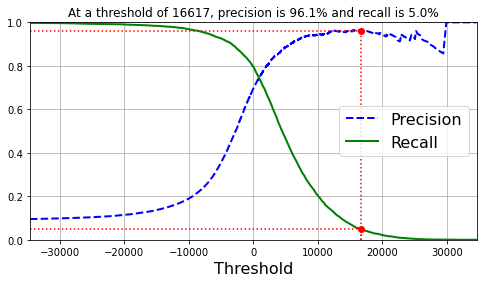

In [28]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmin(recalls >= .05) - 1)

In [29]:
custom_thr = thresholds[np.argmin(recalls >= .05) - 1]
custom_pred = (y_scores >= custom_thr)
print_scores(y_train_5, custom_pred)

Accuracy: 91.4%
Precision: 96.1%
Recall: 5.0%
F1-score: 9.5%


## The ROC Curve

True positive rate vs False positive rate

<table align='left'>
    <tr>
        <th></th>
        <th>non-5</th>
        <th>5</th>
    </tr>
    <tr>
        <th>non-5</th>
        <th>TN</th>
        <th>FP</th>
    </tr>
    <tr>
        <th>5</th>
        <th>FN</th>
        <th>TP</th>
    </tr>
</table>


$ TPR = \frac{Correct5's}{Actual 5's} = \frac{TP}{FN+TP} = Sensitivity $

$ FPR = \frac{Wrong5's}{Actual Non-5's} = \frac{FP}{TN+FP} = 1 - \frac{CorrectNon-5's}{Actual Non-5's} = 1 - Specificity $ 


Proof that FPR is the same as 1-TNR (1 - Specificity)

$ FPR = 1 - TNR $ where $ TNR = \frac{TN}{TN+FP} $

$ FPR = 1 - \frac{TN}{TN+FP} $

$ FPR = -\frac{TN}{TN+FP} + 1 $

$ FPR = \frac{-TN + (TN+FP)}{TN+FP} $

$ FPR = \frac{FP}{TN+FP} $

In [30]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

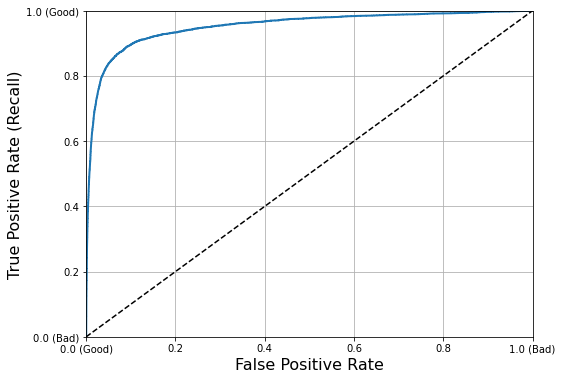

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
xlabels = plt.xticks()[0].round(2).tolist()
xlabels[0] = '0.0 (Good)'
xlabels[-1] = '1.0 (Bad)'
plt.xticks(ticks=plt.xticks()[0], labels=xlabels)
ylabels = plt.yticks()[0].round(2).tolist()
ylabels[0] = '0.0 (Bad)'
ylabels[-1] = '1.0 (Good)'
plt.yticks(ticks=plt.yticks()[0], labels=ylabels)
plt.show()

When the threshold is +Inf, everything is classified as a 5 (upper right corner). The recall is 1 (all 5's are identified) but at the expense of wrongly classifying non-5's (too many false positives FPR=1).

When the threshold is -Inf, everything is classified as non-5 (lower left corner). The FPR is 0 (no false positives) but at the expense of missing all the true positives (recall is 0).

## Probabilistic interpretation of ROC

Given a randomly case belonging to the positive class and a randomly case belonging to the negative class, the area under the ROC is the probability that the positive case outranks (in terms of decision function score) the negative one, so the probability of classifying a random positive as positive and a random negative as negative

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9520055579026794

![](images/ROC.gif)

Image from https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation